<a href="https://colab.research.google.com/github/RonneyPetras/ifood-data-analysis-case/blob/main/02_ab_test_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analise do teste A/B Ifood - Questão 1

## Configurações essenciais



### Importando bibliotecas

In [1]:
import pandas as pd
import os
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency
import numpy as np

### Montando o Gdrive, altere o caminho se necessário

In [2]:
caminho_gdrive = "/content/drive/MyDrive/ifood_case/ifood-data" # @param {"type":"string"}

In [3]:
drive.mount('/content/drive')

# Define caminho (substitua SEU_DIRETORIO pelo nome da pasta que você quer usar)
os.makedirs(caminho_gdrive, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Análises Iniciais

In [4]:
df_pedidos_ab_teste = pd.read_parquet(caminho_gdrive + "/pedidos_teste_ab.parquet")
df_pedidos_ab_teste.head()

,order_id,customer_id,order_total_amount,merchant_id,is_target
0,ec00f7aec2f1b32bdaf6b359a91b60a1f58ce2cb452fed...,665c8547a9ea092ba84342bfc55103f1e8a5068f0a26a7...,32.8,c2b068129a510b4c4ed10ff16081428d077f6d3be44785...,target
1,ee5ba707b0938b565107d0c86b8b4325d4941d06fc73ce...,5e35cb26472772592674730e8907e9e22428354fbd19e6...,38.1,355021c61bb358c499d4d6e4647010a43294463d091c45...,target
2,c4d0992f315f48e2e145afacf302513699147ba43a187e...,56973dab976fe8b32cdeaa0795af4eddba963a5c992535...,50.2,a9ef451e17cb419dce70451a1c9b733d5809a5aa196853...,control
3,992f50eaded5ffcf1ed2ad615b11bef0f226edac4b3430...,5aeb6d21ff3e8f1c04e437d3cf677bf56a9ae899c381ba...,21.0,2f9f3fd5434960270578ca3ea5360ef8eadd4454f67a5d...,control
4,a6d507960380b270f9f19876dd53bd0d23eb5dd8410511...,e80f08f1829cdbf06e2d24cf9880b41ee53f602dff8486...,21.0,3e6131f15538a060e898ec02926240ccee9619fd21710d...,target


## Avaliando os outliers

Problemas:
* Valor minimo igual a 0. Deverá ser expurgado
* Desvio padrão muito distante da média, alta dispersão
* Valor máximo altissimo. Deverá ser expurgado

In [56]:
print(df_pedidos_ab_teste['order_total_amount'].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99]).to_string(float_format='{:.2f}'.format))

count   3670826.00
mean         47.90
std         119.67
min           0.00
25%          26.90
50%          39.90
75%          57.40
95%         108.20
99%         176.80
max      138750.90


Vamos expurgar 1% da base de ambos os extremos mantendo 98%

In [64]:
# Filtro por percentis (exemplo)
expurgo_inferior, expurgo_superior = df_pedidos_ab_teste['order_total_amount'].quantile([0.01, 0.99])
df_expurgado = df_pedidos_ab_teste[(df_pedidos_ab_teste['order_total_amount'] >= expurgo_inferior) & (df_pedidos_ab_teste['order_total_amount'] <= expurgo_superior)]


print(df_expurgado['order_total_amount'].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99]).to_string(float_format='{:.2f}'.format))

count   3597571.00
mean         46.14
std          27.26
min          10.80
25%          27.00
50%          39.90
75%          56.90
95%         102.10
99%         145.50
max         176.80


Com a distribuição expurgada podemos seguir



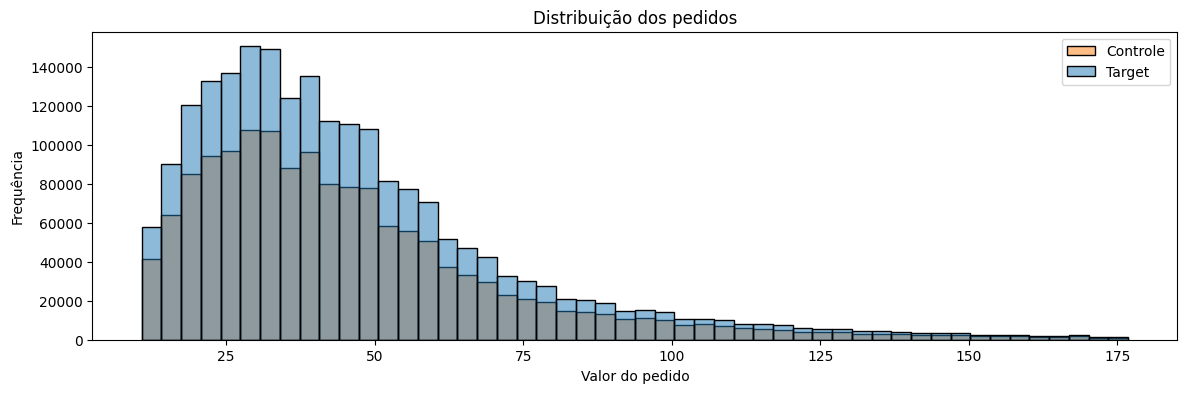

In [85]:
plt.figure(figsize=(14, 4))
sns.histplot(data=df_expurgado, x='order_total_amount', hue='is_target', bins=50)
plt.title('Distribuição dos pedidos')
plt.xlabel('Valor do pedido')
plt.ylabel('Frequência')
plt.legend(labels=['Controle', 'Target'])
plt.show()

Visualização do boxplot sem os outliers

### Indicadores principais

Retenção - Usuários com 2 ou mais pedidos no periodo

In [94]:
# 1. Retenção
retention = df_expurgado.groupby(['customer_id', 'is_target'])['order_id'].count() > 1
df_retidos = retention[retention == True].copy()
df_gb_retencao = retention.groupby('is_target').mean()
df_gb_retencao

,order_id
is_target,
control,0.746321
target,0.793332


Quantidades de usuários retidos

In [105]:
df_qtd_retidos = df_retidos.groupby('is_target').count()
df_qtd_retidos

,order_id
is_target,
control,266068
target,350372


Ticket médio dos pedidos por grupo

In [104]:
df_ticket_medio = df_expurgado.groupby('is_target')['order_total_amount'].mean()
df_ticket_medio

,order_total_amount
is_target,
control,46.132803
target,46.152132


Frequência dos pedidos dos grupos

In [106]:
df_frequencia_pedidos = df_expurgado.groupby(['is_target', 'customer_id'])['order_id'].count().groupby('is_target').mean()
df_frequencia_pedidos

,order_id
is_target,
control,4.195424
target,4.741476


In [108]:
df_teste_hipotese = df_expurgado[['is_target','order_total_amount']].copy()

In [109]:
# Extrai os valores como arrays NumPy (já aplicando dropna())
gp_target = df_teste_hipotese.loc[df_teste_hipotese['is_target'] == 'target','order_total_amount'].dropna().to_numpy(dtype='float32')

gp_controle = df_teste_hipotese.loc[df_teste_hipotese['is_target'] == 'control','order_total_amount'].dropna().to_numpy(dtype='float32')


In [110]:
# Teste de hipotese entre os grupos
t_stat, p_value = ttest_ind(gp_target, gp_controle, method=None)

print(f"""
📊 Resultado do Teste T:
- Estatística T = {t_stat:.4f}
- P-value = {p_value:.10f}  # Notação científica se necessário
""")


📊 Resultado do Teste T:
- Estatística T = 0.6629
- P-value = 0.5074190879  # Notação científica se necessário

